In [1]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow pillow


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import re  # For regular expressions

In [3]:
root_dir = '/kaggle/input/valid-projects-batch-1/Valid_Projects_Batch_1'  # Replace with your actual path


In [4]:
# Get a list of all files in the directory
all_files = os.listdir(root_dir)

# Dictionary to hold files grouped by sample ID
samples = {}

for filename in all_files:
    # Skip directories
    if os.path.isdir(os.path.join(root_dir, filename)):
        continue

    # Use regular expression to extract the sample ID
    # Adjust the regex pattern based on your actual filenames
    match = re.match(r'(.+?)_(bing|google|sigpac|dsm|planes|info)\.(jpg|json)', filename)
    if match:
        sample_id = match.group(1)
        file_type = match.group(2)
        file_ext = match.group(3)

        if sample_id not in samples:
            samples[sample_id] = {}

        samples[sample_id][f"{file_type}.{file_ext}"] = os.path.join(root_dir, filename)
    else:
        print(f"Filename '{filename}' does not match expected pattern.")


In [5]:
json_data = []
labels = []  # If you have labels for supervised learning

# Iterate over each sample
for sample_id, files in samples.items():
    sample_data = {}

    # Check if all required files are present
    required_files = ['bing.jpg', 'google.jpg', 'sigpac.jpg', 'dsm.json']
    if not all(rf in files for rf in required_files):
        print(f"Missing required files for sample '{sample_id}'. Skipping.")
        continue

    # Load images
    try:
        bing_image = Image.open(files['bing.jpg'])
        google_image = Image.open(files['google.jpg'])
        sigpac_image = Image.open(files['sigpac.jpg'])
    except Exception as e:
        print(f"Error loading images for sample '{sample_id}': {e}")
        continue

    # Convert images to numpy arrays
    bing_array = np.array(bing_image)
    google_array = np.array(google_image)
    sigpac_array = np.array(sigpac_image)

    # Store images in the sample data
    sample_data['bing_image'] = bing_array
    sample_data['google_image'] = google_array
    sample_data['sigpac_image'] = sigpac_array

    # Load JSON files
    try:
        with open(files['dsm.json']) as f:
            dsm_json = json.load(f)
        sample_data['dsm'] = dsm_json

        if 'planes.json' in files:
            with open(files['planes.json']) as f:
                planes_json = json.load(f)
            sample_data['planes'] = planes_json

        if 'info.json' in files:
            with open(files['info.json']) as f:
                info_json = json.load(f)
            sample_data['info'] = info_json
    except Exception as e:
        print(f"Error loading JSON files for sample '{sample_id}': {e}")
        continue

    # Append the sample data to our main data list
    json_data.append(sample_data)

    # If you have labels, load them here
    # labels.append(your_label[sample_id])  # Adjust as needed

    # Optional: Print progress
    print(f"Loaded data for sample '{sample_id}'")


In [6]:
def preprocess_image(image_array, target_size=(224, 224)):
    # Resize image
    image = Image.fromarray(image_array).resize(target_size)
    # Normalize pixel values
    image = np.array(image) / 255.0
    return image

# Apply preprocessing to all images
for sample in json_data:
    sample['bing_image'] = preprocess_image(sample['bing_image'])
    sample['google_image'] = preprocess_image(sample['google_image'])
    sample['sigpac_image'] = preprocess_image(sample['sigpac_image'])


In [7]:
def extract_dsm_features(dsm_data):
    # Assuming dsm_data is a list of [x, y, z] points
    dsm_array = np.array(dsm_data)
    features = {}
    features['mean_elevation'] = np.mean(dsm_array[:, 2])
    features['max_elevation'] = np.max(dsm_array[:, 2])
    features['min_elevation'] = np.min(dsm_array[:, 2])
    features['std_elevation'] = np.std(dsm_array[:, 2])
    # Add more features as needed
    return features

# Apply feature extraction to all samples
for sample in json_data:
    dsm_features = extract_dsm_features(sample['dsm'])
    # Merge features into sample data
    sample.update(dsm_features)


In [8]:
# Initialize lists to hold inputs and outputs
X_images = []  # Image data
X_numeric = []  # Numerical features from JSON
y = labels  # Labels (if available)

for sample in json_data:
    # Combine images (stack them along the channel dimension)
    combined_image = np.concatenate([
        sample['bing_image'],
        sample['google_image'],
        sample['sigpac_image']
    ], axis=-1)  # Shape: (height, width, channels*3)

    X_images.append(combined_image)

    # Collect numeric features
    numeric_features = [
        sample['mean_elevation'],
        sample['max_elevation'],
        sample['min_elevation'],
        sample['std_elevation']
        # Add other features extracted from JSON files
    ]
    X_numeric.append(numeric_features)

# Convert lists to numpy arrays
X_images = np.array(X_images)
X_numeric = np.array(X_numeric)


In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Loading and Preprocessing

In [10]:
root_dir = '/kaggle/input/valid-projects-batch-1/Valid_Projects_Batch_1'  # Replace with your actual path

images = []
depth_maps = []

subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, d))]

for subdir in subdirs:
    image_path = os.path.join(subdir, 'bing.jpg')  # Choose one of the images
    dsm_path = os.path.join(subdir, 'dsm.json')

    if not os.path.exists(image_path) or not os.path.exists(dsm_path):
        print(f"Missing files in {subdir}. Skipping.")
        continue

    try:
        image = Image.open(image_path).convert('RGB')
        target_size = (224, 224)
        image = image.resize(target_size)
        image_array = np.array(image) / 255.0  # Normalize
        images.append(image_array)
    except Exception as e:
        print(f"Error loading image in {subdir}: {e}")
        continue

    try:
        with open(dsm_path) as f:
            dsm_data = np.array(json.load(f))
    except Exception as e:
        print(f"Error loading DSM data in {subdir}: {e}")
        continue

    try:
        x = dsm_data[:, 0]
        y = dsm_data[:, 1]
        z = dsm_data[:, 2]

        xi = np.linspace(x.min(), x.max(), target_size[0])
        yi = np.linspace(y.min(), y.max(), target_size[1])
        xi, yi = np.meshgrid(xi, yi)

        from scipy.interpolate import griddata
        zi = griddata((x, y), z, (xi, yi), method='linear')

        mask = np.isnan(zi)
        zi[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), zi[~mask])

        zi = (zi - zi.min()) / (zi.max() - zi.min())

        depth_maps.append(zi)
    except Exception as e:
        print(f"Error processing DSM data in {subdir}: {e}")
        continue

images = np.array(images)
depth_maps = np.array(depth_maps)

print(f"Images shape: {images.shape}")
print(f"Depth maps shape: {depth_maps.shape}")

Images shape: (111, 224, 224, 3)
Depth maps shape: (111, 224, 224)


## Split Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    images, depth_maps, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 88
Testing samples: 23


## Build the Model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    base_model = tf.keras.applications.MobileNetV2(
        input_tensor=inputs, include_top=False, weights='imagenet')

    base_model.trainable = False

    x = base_model.output

    x = layers.Conv2DTranspose(512, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same')(x)
    outputs = layers.Activation('sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model(input_shape=(224, 224, 3))
model.summary()

/tmp/ipykernel_30/3476213501.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 9,709,889 (37.04 MB)

 Trainable params: 7,449,985 (28.42 MB)

 Non-trainable params: 2,259,904 (8.62 MB)

## Compile and Train the Model

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test)
)

Epoch 1/10


I0000 00:00:1730304158.554257      97 service.cc:145] XLA service 0x7c0ab80147d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730304158.554329      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730304158.554335      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1057 - mae: 0.2839 

I0000 00:00:1730304169.814189      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0965 - mae: 0.2698  

I0000 00:00:1730304177.238610      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 136 bytes spill stores, 136 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 304 bytes spill stores, 344 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 0.0953 - mae: 0.2679 - val_loss: 0.1019 - val_mae: 0.2803
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0708 - mae: 0.2269 - val_loss: 0.1225 - val_mae: 0.3049
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0660 - mae: 0.2162 - val_loss: 0.1363 - val_mae: 0.3214
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0599 - mae: 0.2014 - val_loss: 0.1226 - val_mae: 0.3053
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0574 - mae: 0.1962 - val_loss: 0.1202 - val_mae: 0.3026
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0574 - mae: 0.1963 - val_loss: 0.1104 - val_mae: 0.2910
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0547 - mae: 0.1908 - val_loss: 0.1165 - val_mae: 0.2980
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0581 - mae: 0.1960 - val_loss: 0.1015 - val_mae: 0.2793
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0537 - mae: 0.1889 - val_loss: 0.

## Evaluate the Model

In [14]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Test MAE: {test_mae}")

y_pred = model.predict(X_test)


1/1 - 6s - 6s/step - loss: 0.0968 - mae: 0.2718
Test MAE: 0.2718064785003662
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


## Compute Thresholded Accuracy

In [15]:
def compute_thresholded_accuracy(y_true, y_pred, threshold=1.25):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    ratio = np.maximum(y_true / y_pred, y_pred / y_true)
    accuracy = np.mean(ratio < threshold)
    return accuracy

thresholds = [1.25, 1.25 ** 2, 1.25 ** 3]
for th in thresholds:
    acc = compute_thresholded_accuracy(y_test, y_pred, threshold=th)
    print(f"Threshold = {th:.2f}, Accuracy = {acc:.4f}")


Threshold = 1.25, Accuracy = 0.1907
Threshold = 1.56, Accuracy = 0.3483
Threshold = 1.95, Accuracy = 0.4870


/tmp/ipykernel_30/3103067009.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio = np.maximum(y_true / y_pred, y_pred / y_true)


In [16]:
# Save the entire model as an HDF5 file
model.save('MobileNetV2_model.h5')
print("Model saved to MobileNetV2_model.h5")

Model saved to MobileNetV2_model.h5


## Visualize Training History

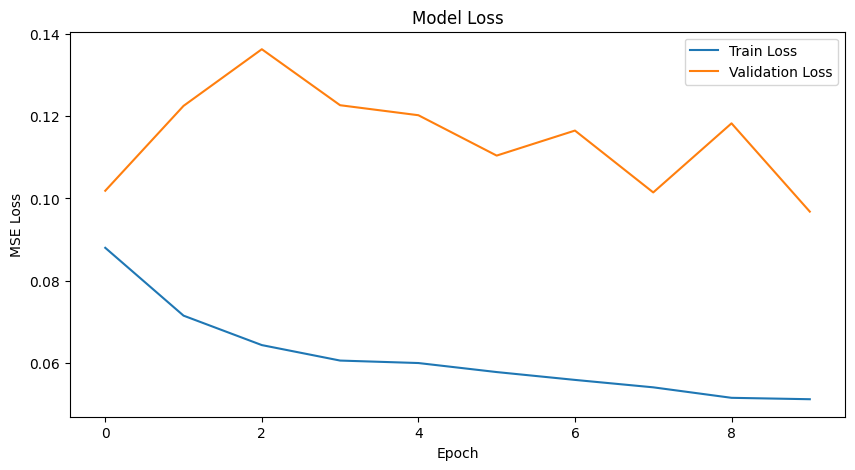

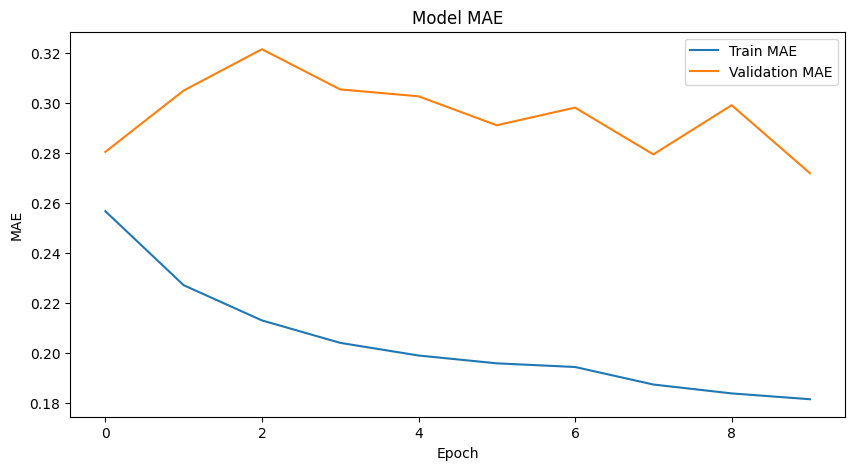

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Visualize Predictions

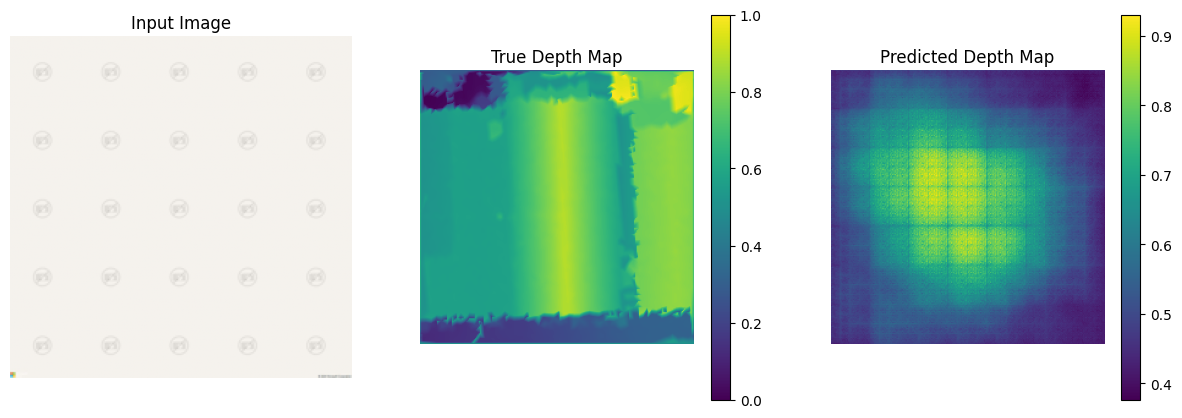

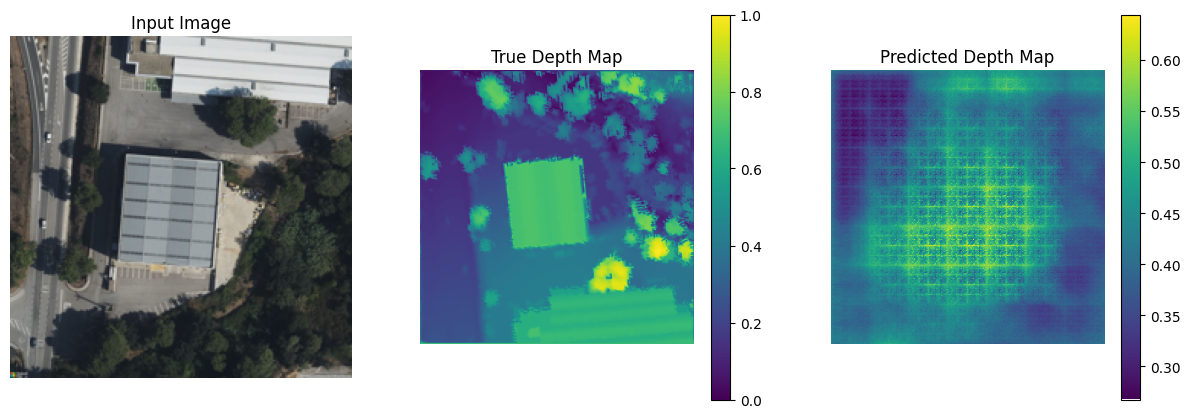

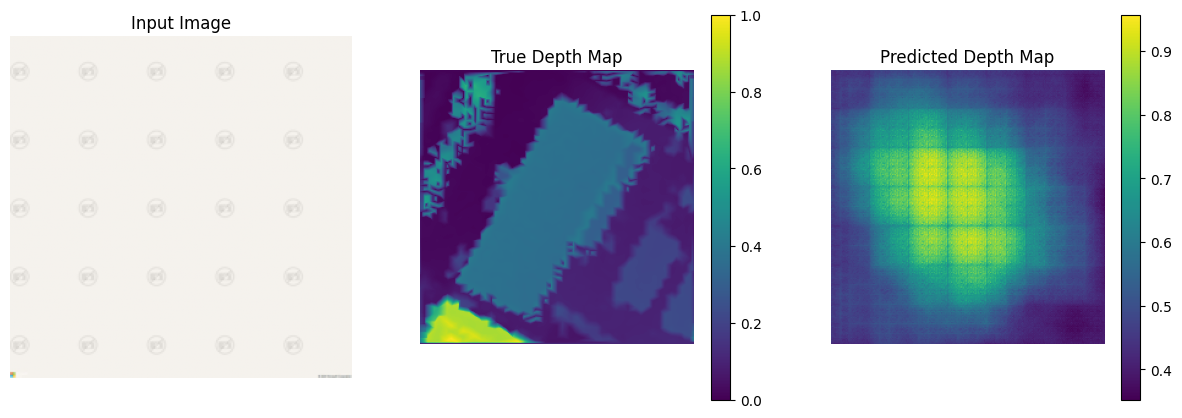

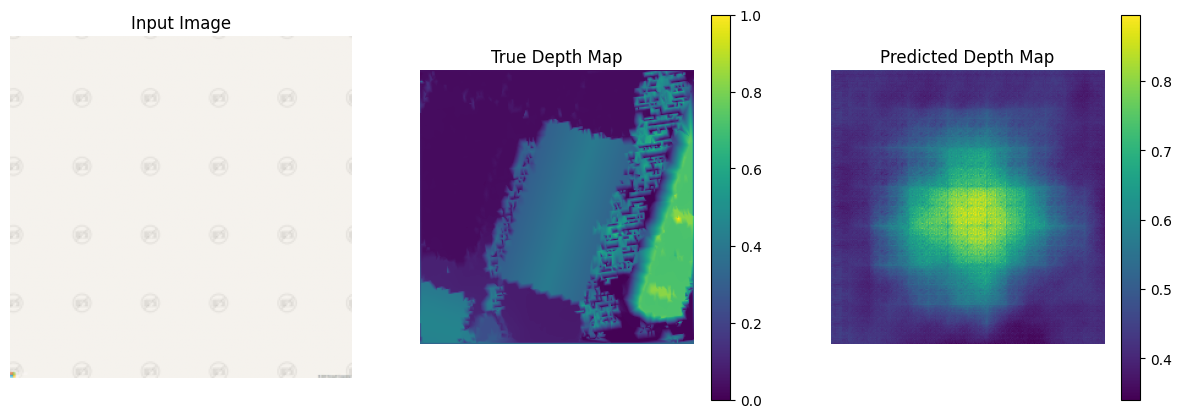

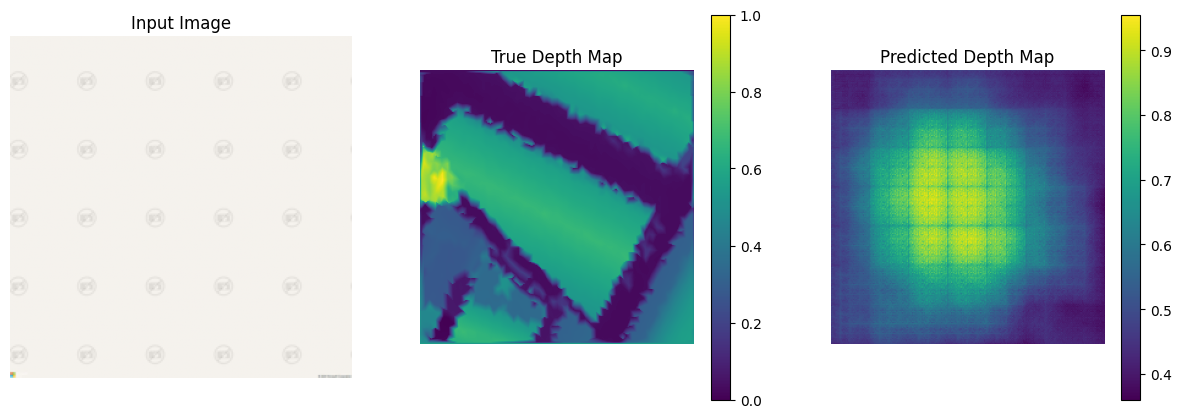

In [18]:
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in indices:
    img = X_test[idx]
    true_depth = y_test[idx]
    pred_depth = y_pred[idx]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_depth, cmap='viridis')
    plt.title('True Depth Map')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(pred_depth, cmap='viridis')
    plt.title('Predicted Depth Map')
    plt.axis('off')
    plt.colorbar()

    plt.show()